In [52]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
from scipy import signal

In [26]:
# Function to load the MSTAR dataset and resize to 128 * 128
def get_MSTAR(train_dir, val_dir, test_dir):
    def load_images_from_folder(folder):
        images = []
        labels = []
        for label in os.listdir(folder):
            label_folder = os.path.join(folder, label)
            if os.path.isdir(label_folder):
                for filename in os.listdir(label_folder):
                    img_path = os.path.join(label_folder, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize image to 128x128
                        img_resized = cv2.resize(img, (100, 100))
                        images.append(img_resized)
                        labels.append(label)
        return np.array(images), np.array(labels)

    X_train, y_train = load_images_from_folder(train_dir)
    X_val, y_val = load_images_from_folder(val_dir)
    X_test, y_test = load_images_from_folder(test_dir)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Function to display trained, validated, and tested sets
def display_class_counts(y_train, y_val, y_test):
    train_counts = Counter(y_train)
    val_counts = Counter(y_val)
    test_counts = Counter(y_test)
    classes = sorted(set(train_counts.keys()).union(set(val_counts.keys()).union(set(test_counts.keys()))))
    print(f"{'Class':<10} {'Train Count':<12} {'Val Count':<12} {'Test Count':<10}")
    print("="*44)
    for cls in classes:
        train_count = train_counts.get(cls, 0)
        val_count = val_counts.get(cls, 0)
        test_count = test_counts.get(cls, 0)
        print(f"{cls:<10} {train_count:<12} {val_count:<12} {test_count:<10}")

# Path to the training, validation, and testing datasets
train_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TRAIN'
val_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/VAL'
test_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TEST'

In [27]:

# Dataset loading
X_train, y_train, X_val, y_val, X_test, y_test = get_MSTAR(train_dir, val_dir, test_dir)
display_class_counts(y_train, y_val, y_test)

Class      Train Count  Val Count    Test Count
2S1        230          80           141       
BRDM_2     230          80           141       
BTR_60     230          80           141       
D7         230          80           141       
SLICY      230          80           141       
T62        230          80           141       
ZIL131     230          80           141       
ZSU_23_4   230          80           141       


In [28]:

# Normalize the image data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape the input data for CNN
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)

In [29]:
# Encode the labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Convert to categorical
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)


In [30]:
def create_cnn_model(input_shape=(100, 100, 1), num_classes=8):
    model = Sequential([
        Conv2D(20, kernel_size=(5, 5), strides=(5, 5), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(num_classes, activation='softmax')  # Add a Dense layer for classification
    ])
    return model

In [31]:
# Compile the model
num_classes = len(le.classes_)  # Ensure this matches the number of unique classes
model = create_cnn_model(input_shape=(100, 100, 1), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat))


Epoch 1/10


/home/nathan/anaconda3/envs/MLenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1980 - loss: 1.9714 - val_accuracy: 0.4563 - val_loss: 1.4679
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5670 - loss: 1.2861 - val_accuracy: 0.8078 - val_loss: 0.8026
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8296 - loss: 0.6909 - val_accuracy: 0.8672 - val_loss: 0.5093
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9151 - loss: 0.3910 - val_accuracy: 0.8828 - val_loss: 0.3860
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 0.2554 - val_accuracy: 0.9359 - val_loss: 0.2655
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9743 - loss: 0.1831 - val_accuracy: 0.9453 - val_loss: 0.2156
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9895 - loss: 0.1110 - val_accuracy: 0.9469 - val_loss: 0.1838
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9870 - loss: 0.0808 - val_accuracy: 0.9688 - val_loss: 0.1407
Epo

In [32]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8996 - loss: 0.2868
Test accuracy: 0.9424
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

         2S1       0.96      0.91      0.93       141
      BRDM_2       0.99      0.90      0.94       141
      BTR_60       0.85      0.99      0.91       141
          D7       1.00      0.99      0.99       141
       SLICY       1.00      1.00      1.00       141
         T62       0.99      0.82      0.89       141
      ZIL131       0.98      0.95      0.96       141
    ZSU_23_4       0.82      0.99      0.90       141

    accuracy                           0.94      1128
   macro avg       0.95      0.94      0.94      1128
weighted avg       0.95      0.94      0.94      1128



In [33]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 20)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │        64,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,586 (756.20 KB)

 Trainable params: 64,528 (252.06 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,058 (504.14 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/home/nathan/anaconda3/envs/MLenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


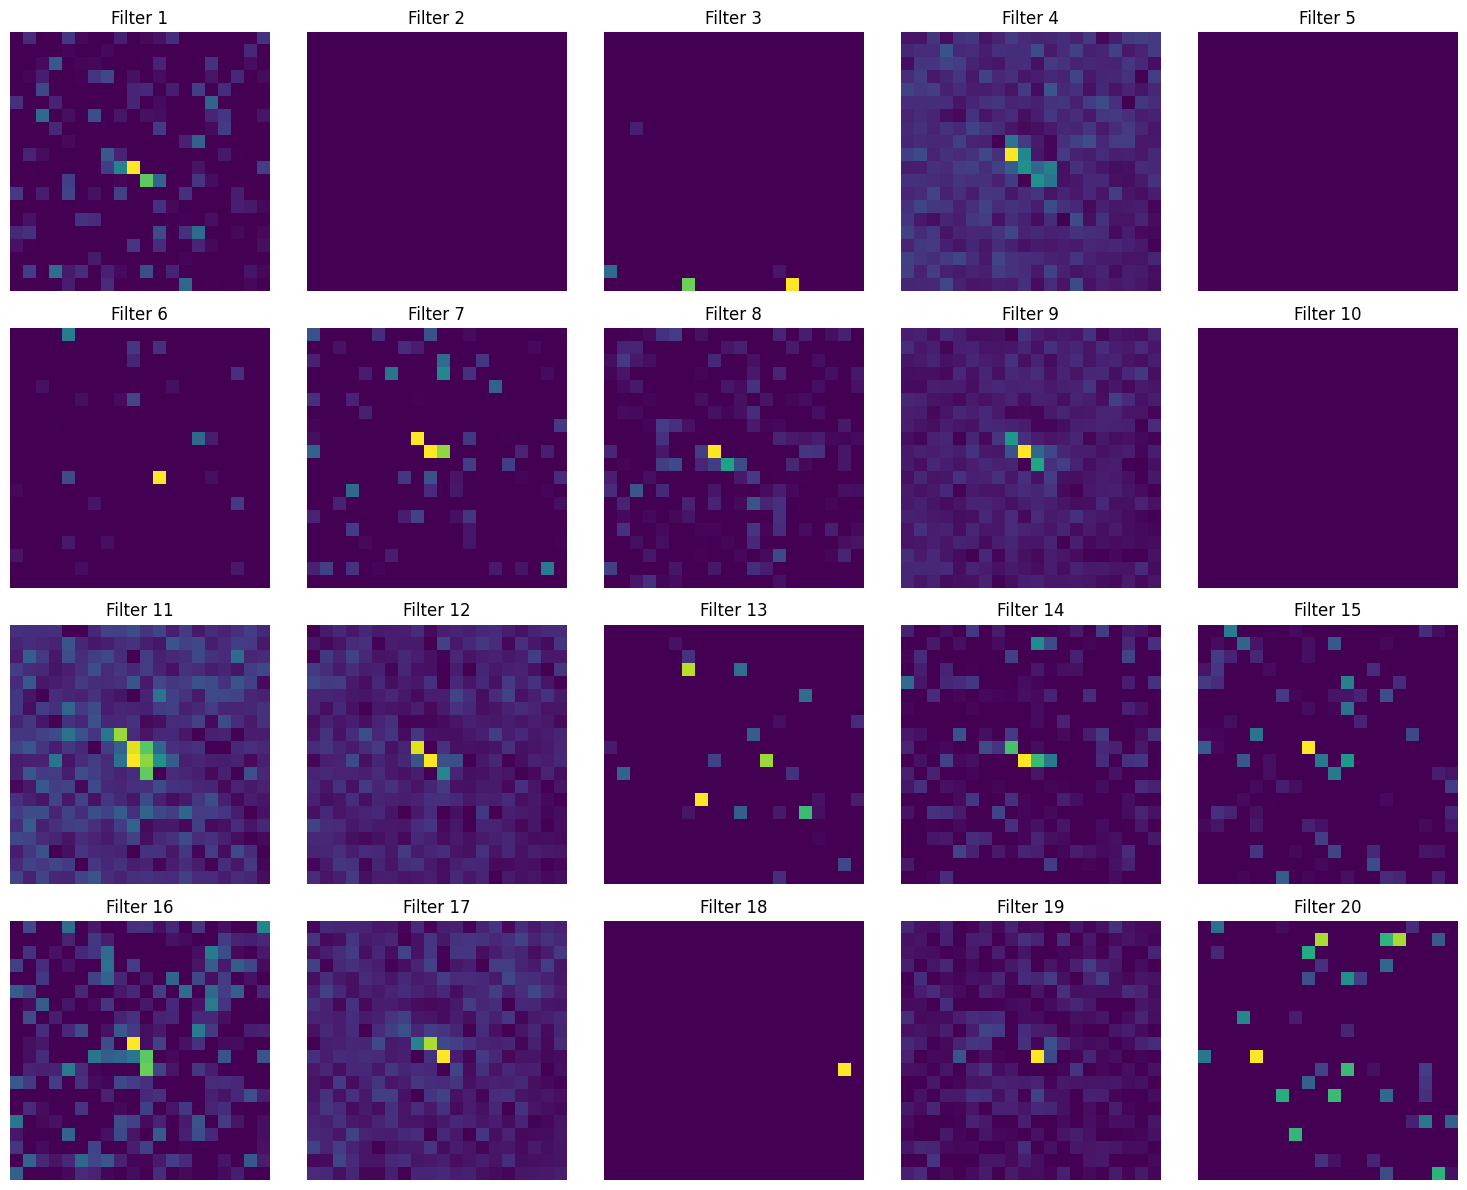

In [34]:
# Create the original model
original_model = create_cnn_model()

# Create a new model that outputs the Conv2D layer activations
conv_layer = original_model.layers[0]
feature_model = Model(inputs=original_model.inputs, outputs=conv_layer.output)

# Generate a random input image (you should use your actual input image here)
img_path = '/home/nathan/Documents/EEE4022S/New/DATASET/TRAIN/T62/HB19877.JPG'  # Replace with your image path
img = load_img(img_path, target_size=(100, 100), color_mode='grayscale')
input_image = img_to_array(img)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension


# Get the feature maps
feature_maps = feature_model.predict(input_image)

# Plot the feature maps
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    if i < feature_maps.shape[3]:
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Get the feature maps
feature_maps = feature_model.predict(input_image)

# Select the first feature map (you can change the index to select a different one)
selected_feature_map = feature_maps[0, :, :, 0]

# Normalize the feature map to 0-255 range
normalized_feature_map = ((selected_feature_map - selected_feature_map.min()) * (1/(selected_feature_map.max() - selected_feature_map.min()) * 255)).astype('uint8')

# Create a figure (without displaying it)
plt.figure(figsize=(5, 5))
plt.imshow(normalized_feature_map, cmap='viridis')
plt.axis('off')

# Save the figure as a JPG file
plt.savefig('conv_layer_output.jpg', bbox_inches='tight', pad_inches=0)
plt.close()  # Close the figure to free up memory

print("test.jpg'")

In [ ]:
# Save the output as a NumPy array


print(f"Conv2D layer output shape: {feature_maps.shape}")
print("Output saved as 'last_conv_layer_output.npy'")

In [ ]:
# Assuming your model is called 'model'
conv_layer = model.layers[0]  # The Conv2D layer is the first layer (index 0)
weights = conv_layer.get_weights()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


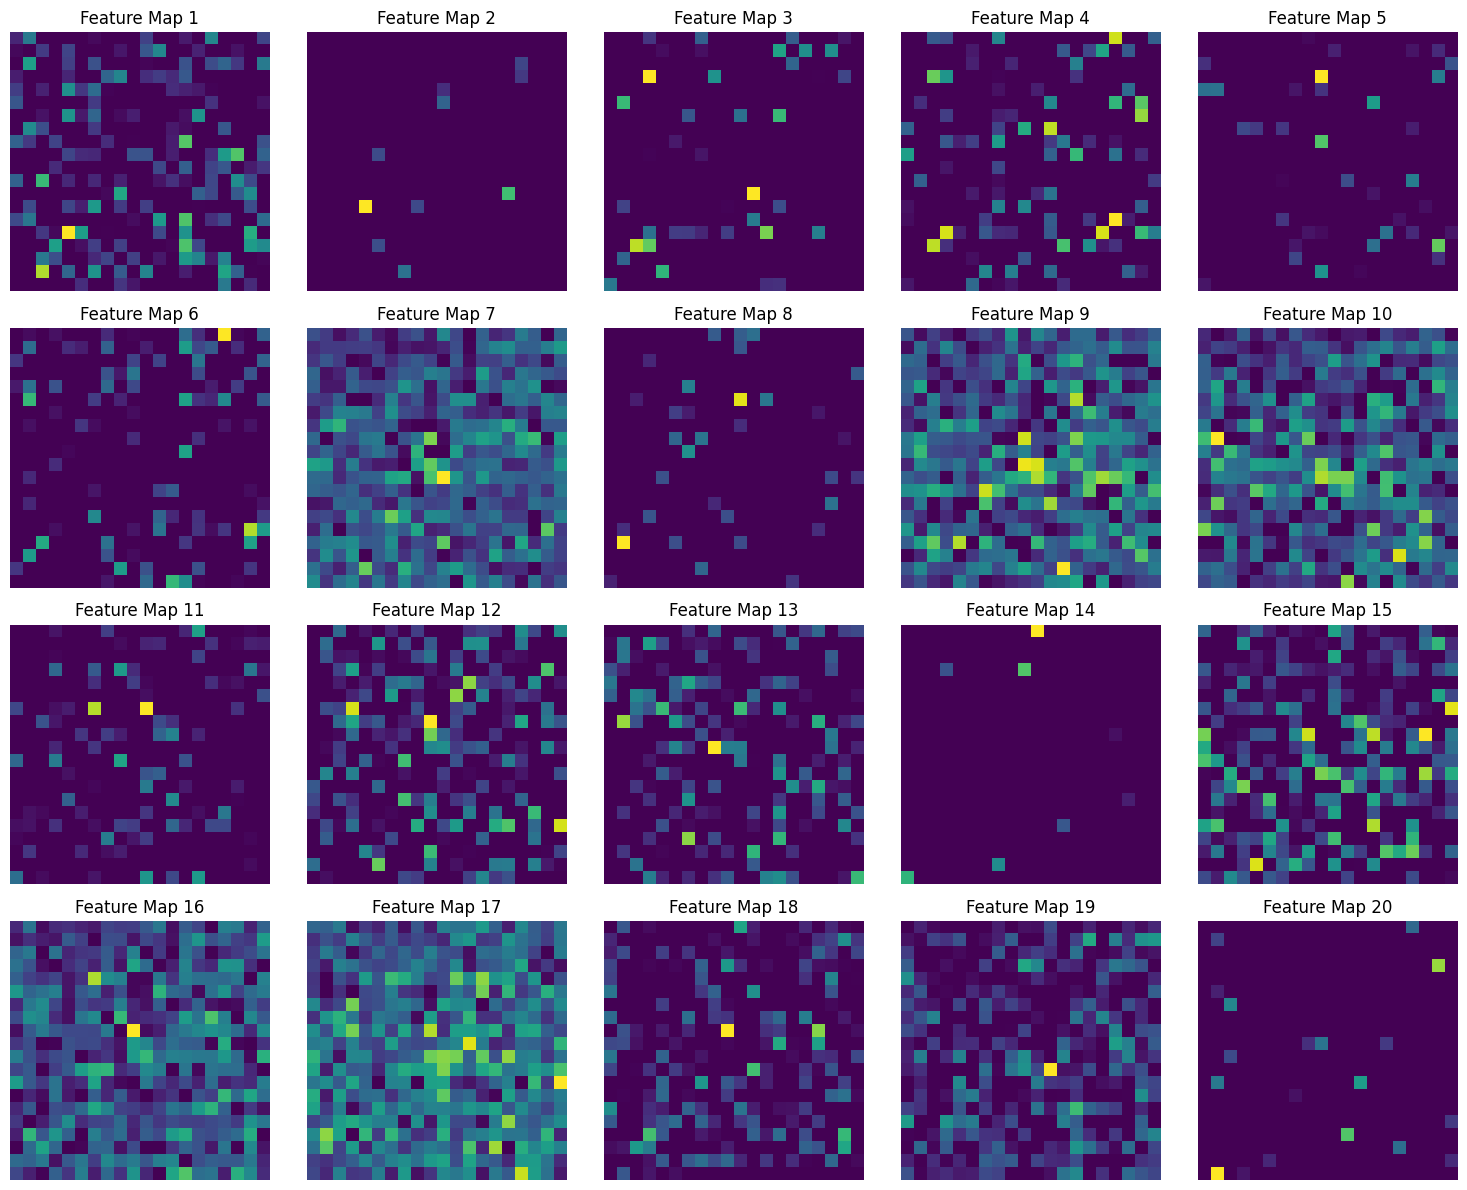

Number of feature maps: 20
Shape of each feature map: (20, 20)


In [35]:
def display_feature_maps(model, image, num_feature_maps=20):
    # Create a new model that outputs the feature maps from the Conv2D layer
    feature_map_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
    
    # Expand dimensions to create a batch of size 1
    image = np.expand_dims(image, axis=0)
    
    # Get feature maps
    feature_maps = feature_map_model.predict(image)
    
    # Squeeze the batch dimension
    feature_maps = np.squeeze(feature_maps)
    
    # Ensure we don't try to display more feature maps than we have
    num_feature_maps = min(num_feature_maps, feature_maps.shape[2])
    
    # Plot feature maps
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    for i in range(num_feature_maps):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(feature_maps[:, :, i], cmap='viridis')
        axes[row, col].set_title(f'Feature Map {i+1}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return feature maps as separate NumPy arrays
    return [feature_maps[:, :, i] for i in range(num_feature_maps)]

# Example usage
X_train, y_train, X_val, y_val, X_test, y_test = get_MSTAR(train_dir, val_dir, test_dir)

# Create and compile the model
model = create_cnn_model(input_shape=(100, 100, 1), num_classes=8)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Select an image (e.g., the first image from the training set)
selected_image = X_train[0]

# Display feature maps and get them as separate NumPy arrays
feature_map_arrays = display_feature_maps(model, selected_image)

# Now feature_map_arrays contains 20 separate NumPy arrays, each representing a feature map
print(f"Number of feature maps: {len(feature_map_arrays)}")
print(f"Shape of each feature map: {feature_map_arrays[0].shape}")

In [36]:
print(feature_map_arrays[0])


[[ 3.4742842  13.467699    0.          0.          0.          0.
   0.83194906  0.          0.          0.          6.4014444   0.
   0.          2.3643968   0.         15.344251    0.          0.
   0.          6.995566  ]
 [ 0.70521134  0.          5.6858726   0.          6.88463     0.
   0.          0.          1.9740008   0.          9.092469   15.401076
   0.          0.          3.193515    0.          0.          1.5896012
   0.          0.        ]
 [ 0.         18.75598     0.          0.          6.368287    0.
   8.225604    0.          0.          0.          0.5087055   0.
   0.          8.365263    0.          7.748264   10.728772    5.3778973
   0.         13.709217  ]
 [ 2.6271524   0.          0.          0.          3.4801092   0.08370557
   0.         10.927946   15.190569    0.          4.316022    5.905504
   3.9377866   9.166208    0.          0.          0.          0.
   0.          0.        ]
 [ 6.0534062   0.          3.071905    0.         16.678818    5.4

In [37]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
X_test_flat = flatten_images(X_test)

# Standardize data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

In [38]:
pca = PCA(n_components=20)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train_flat)

In [39]:
# Compute the covariance matrix of the PCA-transformed data
cov_matrix = np.cov(X_train_pca, rowvar=False)

# Save the covariance matrix as a numpy array
np.save('cov_matrix.npy', cov_matrix)


In [40]:
cov_matrix.shape


(20, 20)

In [41]:
print(cov_matrix)

[[ 4.66550021e+03  6.72600758e-14 -1.62215477e-13  3.85756317e-14
  -2.69534863e-14  4.45103443e-14  2.18224327e-14 -1.48367814e-15
  -9.89118762e-15 -6.92383133e-15 -2.96735629e-14  1.13748658e-14
   5.93471257e-15  1.97823752e-15 -4.05538692e-14  6.23144820e-14
   1.43422221e-14 -4.94559381e-15  6.92383133e-15 -2.07714940e-14]
 [ 6.72600758e-14  1.09021965e+02 -3.31354785e-14  9.14934855e-15
  -9.89118762e-15  1.05712068e-14  7.44930068e-15 -3.46191567e-15
   3.21463598e-15 -6.55291180e-15 -8.40750948e-15  6.67655164e-15
  -6.42927195e-15  4.57467427e-15  3.21463598e-15 -2.10187737e-15
  -3.95647505e-15  4.94559381e-16 -4.20375474e-15 -3.21463598e-15]
 [-1.62215477e-13 -3.31354785e-14  9.30988746e+01  1.92684971e-14
  -4.54994631e-14  1.26112642e-14 -2.05551243e-15  3.21463598e-15
   2.96735629e-15  1.08803064e-14  5.93471257e-15 -3.46191567e-15
   6.18199226e-16 -1.88550764e-15  7.91295010e-15 -7.41839072e-16
   4.32739458e-15  4.20375474e-15  1.29821838e-15  3.09099613e-15]
 [ 3.85

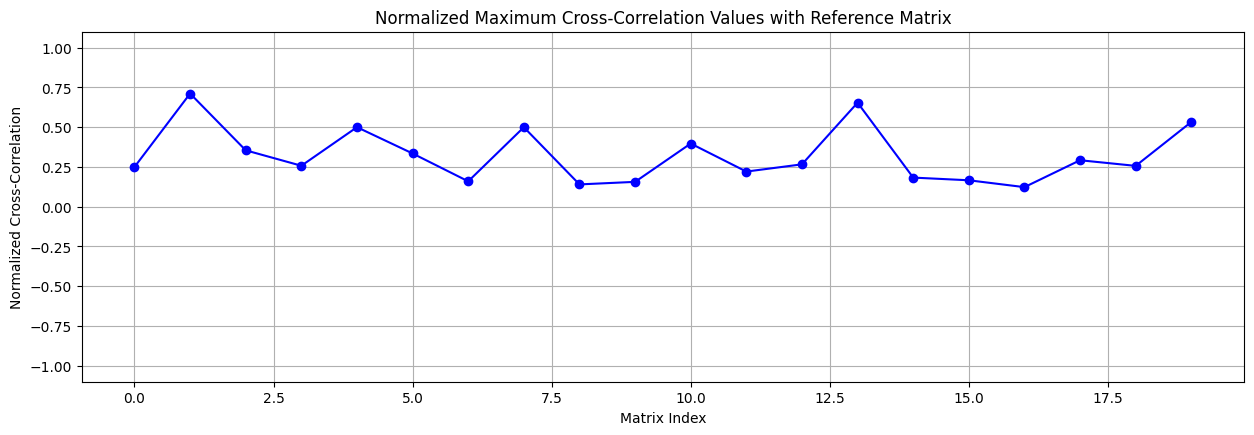

In [55]:
def compute_normalized_cross_correlation_2d(reference, target):
    """
    Compute normalized 2D cross-correlation between reference and target matrices.
    Returns maximum correlation value and its position.
    """
    # Compute cross-correlation
    cross_corr = signal.correlate2d(reference, target, mode='full', boundary='fill')
    
    # Normalize by the geometric mean of autocorrelations at zero lag
    ref_auto = np.sum(reference ** 2)
    target_auto = np.sum(target ** 2)
    
    normalized_cross_corr = cross_corr / np.sqrt(ref_auto * target_auto)
    
    # Find the maximum correlation value and its position
    max_corr = np.max(np.abs(normalized_cross_corr))
    max_idx = np.unravel_index(np.argmax(np.abs(normalized_cross_corr)), normalized_cross_corr.shape)
    
    # Calculate the lag at maximum correlation
    center_y, center_x = np.array(normalized_cross_corr.shape) // 2
    lag_y = max_idx[0] - center_y
    lag_x = max_idx[1] - center_x
    
    return max_corr, (lag_y, lag_x), normalized_cross_corr

def analyze_matrix_cross_correlations(reference_matrix, matrices_list):
    """
    Analyze normalized cross-correlations between a reference matrix and a list of matrices.
    """
    max_correlations = []
    lags = []
    full_correlations = []
    
    for matrix in matrices_list:
        max_corr, lag, full_corr = compute_normalized_cross_correlation_2d(reference_matrix, matrix)
        max_correlations.append(max_corr)
        lags.append(lag)
        full_correlations.append(full_corr)
    
    return max_correlations, lags, full_correlations

def plot_cross_correlations(max_correlations, lags, full_correlations, matrix_idx=0):
    """
    Create visualizations for normalized cross-correlation analysis results.
    """
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 2)
    
    # Plot 1: Maximum correlation values
    ax1 = fig.add_subplot(gs[0, :])
    indices = list(range(len(max_correlations)))
    ax1.plot(indices, max_correlations, 'b-', marker='o')
    ax1.set_title('Normalized Maximum Cross-Correlation Values with Reference Matrix')
    ax1.set_xlabel('Matrix Index')
    ax1.set_ylabel('Normalized Cross-Correlation')
    ax1.grid(True)
    # Set y-axis limits to show full correlation range
    ax1.set_ylim(-1.1, 1.1)
    
    
    return fig

# Example usage

max_correlations, lags, full_correlations = analyze_matrix_cross_correlations(cov_matrix, feature_map_arrays)
plot_cross_correlations(max_correlations, lags, full_correlations)
plt.show()
